# BiLSTMs for text classification.

This notebook was run on google colab to have access to hardware acceleration in the form of GPUs. We recommend to make sure that hardware acceleration is available to improve computation time for this notebook.

We first check that we have access to GPUs before implementing two BiLSTMs network for classification. We apply this model to both the full and undersampled datasets.

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 19 11:00:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Setup 
import numpy as np
import warnings

# Ignore FutureWarning from NumPy
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, LSTM
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as npb

In [6]:
df_train = pd.read_csv('normalized_train.csv')
df_test = pd.read_csv('normalized_test.csv')
df_under_train = pd.read_csv('undersampled_train.csv')
df_under_test = pd.read_csv('undersampled_test.csv')

In [7]:
max_features = 20000  # Use top 20k words
max_len = int(df_train["Data"].str.len().max()) # Use the longest string as max length value
embedding_dim = 128

In [8]:
max_features = 20000  # Use top 20k words
max_len_under = int(df_under_train["Data"].str.len().max()) # Use the longest string as max length value
embedding_dim = 128

In [9]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['Data'].values.astype(str))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 46710 unique tokens.


In [10]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_under_train['Data'].values.astype(str))
word_index = tokenizer.word_index
print('Found %s unique tokens for undersampled data.' % len(word_index))

Found 34784 unique tokens for undersampled data.


In [11]:
def tokenize_for_lstm(X, Y, MAX_NB_WORDS=max_features, MAX_SEQUENCE_LENGTH=max_len):
    X = tokenizer.texts_to_sequences(X.values)
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print(f'Shape of data tensor: {X.shape}')
    Y = pd.get_dummies(Y).values
    print(f'Shape of label tensor: {Y.shape}')
    return X, Y

In [12]:
X_train_tokenized, Y_train_tokenized = tokenize_for_lstm(df_train['Data'], df_train['Label'])

Shape of data tensor: (9446, 3448)
Shape of label tensor: (9446, 4)


In [13]:
X_test_tokenized, Y_test_tokenized = tokenize_for_lstm(df_test['Data'], df_test['Label'])

Shape of data tensor: (2354, 3448)
Shape of label tensor: (2354, 4)


In [14]:
X_train_tokenized_under, Y_train_tokenized_under = tokenize_for_lstm(df_under_train['Data'], df_under_train['Label'])

Shape of data tensor: (6152, 3448)
Shape of label tensor: (6152, 4)


In [15]:
X_test_tokenized_under, Y_test_tokenized_under = tokenize_for_lstm(df_under_test['Data'], df_under_test['Label'])

Shape of data tensor: (1412, 3448)
Shape of label tensor: (1412, 4)


## BiLSTM for the full dataset

Here we apply the BiLSTM model for the full dataset and analyze the results by producing the precision, recall and f1-score.

In [16]:
# Setup 
import warnings

# Ignore FutureWarning from NumPy
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X_train_tokenized.shape[1]))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train_tokenized, Y_train_tokenized, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
133/133 [==============================] - 74s 476ms/step - loss: 0.7954 - accuracy: 0.6779 - val_loss: 0.5372 - val_accuracy: 0.8053
Epoch 2/5
133/133 [==============================] - 62s 469ms/step - loss: 0.4049 - accuracy: 0.8492 - val_loss: 0.4170 - val_accuracy: 0.8455
Epoch 3/5
133/133 [==============================] - 63s 476ms/step - loss: 0.2383 - accuracy: 0.9245 - val_loss: 0.4086 - val_accuracy: 0.8561
Epoch 4/5
133/133 [==============================] - 63s 471ms/step - loss: 0.1477 - accuracy: 0.9559 - val_loss: 0.4739 - val_accuracy: 0.8434
Epoch 5/5
133/133 [==============================] - 62s 469ms/step - loss: 0.0870 - accuracy: 0.9764 - val_loss: 0.5490 - val_accuracy: 0.8328


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3448, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 3448, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 2,758,148
Trainable params: 2,758,148
Non-trainable params: 0
_________________________________________________________________


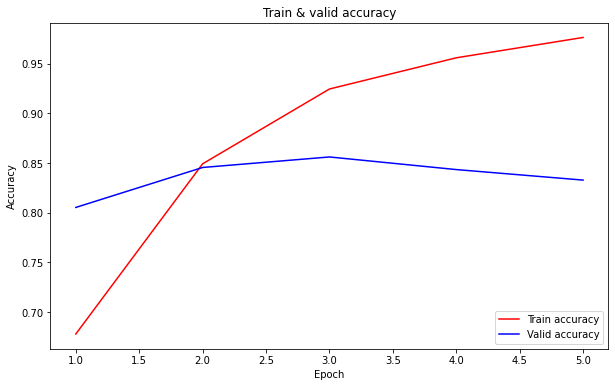

In [18]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.plot(epochs, acc, '-r', label = 'Train accuracy')
plt.plot(epochs, val_acc, '-b', label = 'Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & valid accuracy')
plt.legend(loc = 4)
plt.show()

In [19]:
accr = model.evaluate(X_test_tokenized, Y_test_tokenized)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

74/74 [==============================] - 13s 169ms/step - loss: 0.5651 - accuracy: 0.8292
Test set
  Loss: 0.565
  Accuracy: 0.829


In [20]:
# Predictions on test_data
Y_pred = model.predict(X_test_tokenized)
Y_pred = np.argmax(Y_pred, axis = 1)

# Predictions on test_data
Y_test_tokenized = np.argmax(Y_test_tokenized, axis = 1)

# Evaluate model reporting accuracy, precision, recall and F1
print(classification_report(Y_test_tokenized, Y_pred))

74/74 [==============================] - 14s 169ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       840
           1       0.92      0.83      0.87       353
           2       0.93      0.96      0.95       785
           3       0.60      0.58      0.59       376

    accuracy                           0.83      2354
   macro avg       0.81      0.80      0.80      2354
weighted avg       0.83      0.83      0.83      2354



## BiLSTM for text classification with undersampled dataset

We perform the same work than in the previous section on the undersampled dataset. We do not modify the model and network for this task to ensure fair comparison between the two datasets.

In [21]:
# Setup 
import warnings

# Ignore FutureWarning from NumPy
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional

model_under = Sequential()
model_under.add(Embedding(max_features, embedding_dim, input_length=X_train_tokenized_under.shape[1]))
model_under.add(Bidirectional(LSTM(64, return_sequences = True)))
model_under.add(Bidirectional(LSTM(64, dropout=0.2)))
model_under.add(Dense(4, activation='softmax'))
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history_under = model_under.fit(X_train_tokenized_under, Y_train_tokenized_under, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
87/87 [==============================] - 47s 484ms/step - loss: 0.8684 - accuracy: 0.5854 - val_loss: 0.5103 - val_accuracy: 0.7094
Epoch 2/5
87/87 [==============================] - 41s 475ms/step - loss: 0.4382 - accuracy: 0.7849 - val_loss: 0.4980 - val_accuracy: 0.7922
Epoch 3/5
87/87 [==============================] - 41s 470ms/step - loss: 0.2401 - accuracy: 0.9129 - val_loss: 0.4935 - val_accuracy: 0.8231
Epoch 4/5
87/87 [==============================] - 40s 464ms/step - loss: 0.1331 - accuracy: 0.9615 - val_loss: 0.5912 - val_accuracy: 0.8133
Epoch 5/5
87/87 [==============================] - 40s 464ms/step - loss: 0.0672 - accuracy: 0.9827 - val_loss: 0.7192 - val_accuracy: 0.8036


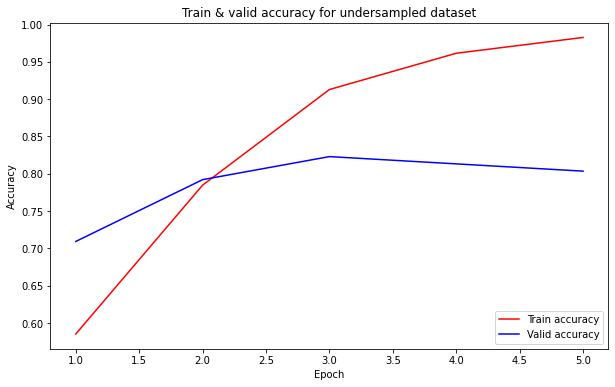

In [22]:
history_dict_under = history_under.history
acc_under = history_dict_under['accuracy']
val_acc_under = history_dict_under['val_accuracy']
loss_under = history_dict_under['loss']
val_loss_under = history_dict_under['val_loss']
epochs = range(1, len(acc_under) + 1)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.plot(epochs, acc_under, '-r', label = 'Train accuracy')
plt.plot(epochs, val_acc_under, '-b', label = 'Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & valid accuracy for undersampled dataset')
plt.legend(loc = 4)
plt.show()


In [23]:
accr_under = model.evaluate(X_test_tokenized_under, Y_test_tokenized_under)
print('Test set (undersampled data)\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_under[0],accr_under[1]))

45/45 [==============================] - 7s 164ms/step - loss: 0.6786 - accuracy: 0.7989
Test set (undersampled data)
  Loss: 0.679
  Accuracy: 0.799


In [24]:
# Predictions on test_data
Y_pred_under = model.predict(X_test_tokenized_under)
Y_pred_under = np.argmax(Y_pred_under, axis = 1)

# Predictions on test_data
Y_test_tokenized_under = np.argmax(Y_test_tokenized_under, axis = 1)

# Evaluate model reporting accuracy, precision, recall and F1
print(classification_report(Y_test_tokenized_under, Y_pred_under))

45/45 [==============================] - 7s 161ms/step
              precision    recall  f1-score   support

           0       0.65      0.81      0.72       353
           1       0.95      0.83      0.89       353
           2       0.89      0.96      0.93       353
           3       0.73      0.59      0.65       353

    accuracy                           0.80      1412
   macro avg       0.81      0.80      0.80      1412
weighted avg       0.81      0.80      0.80      1412



We observe an decrease in performance on the computed metrics except for the class 3 (Statistics) that sees an increase in performance most likely due to the undersampling that reduces the bias of the dataset due to class distributions.

In [25]:
# We save both models as pickle files for further use

import pickle

# save the model to disk
with open('bilstm_model.sav', 'wb') as f:
  pickle.dump(model, f)

# Save other model to disk
filename_under = 'bilstm_model_undersampled.sav'
with open('bilstm_model_undersampled.sav', 'wb') as f:
  pickle.dump(model_under, f)

## ROC curves for full and undersampled datasets

We find the ROC curves for the one-vs-rest of the class 'Statistics' (class 3). We also present the micro-averaged ROC curves as they are better suited to describe the true underlying ROC for multiclass classification and the one-vs-rest ROC interpretation.

In [26]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(Y_train_tokenized)
y_onehot_test = label_binarizer.transform(Y_test_tokenized)
y_onehot_test.shape  # (n_samples, n_classes)

(2354, 4)

In [27]:
class_of_interest = 3
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

3

74/74 [==============================] - 13s 173ms/step


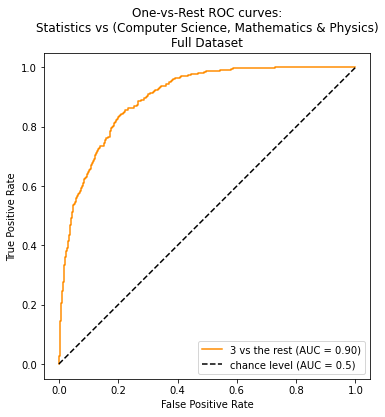

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    model.predict(X_test_tokenized)[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nStatistics vs (Computer Science, Mathematics & Physics)\nFull Dataset")
plt.legend()
plt.show()

74/74 [==============================] - 12s 166ms/step


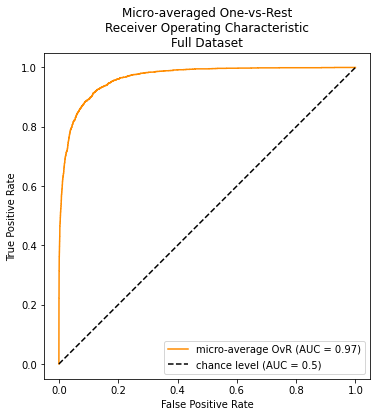

In [29]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    model.predict(X_test_tokenized).ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nFull Dataset")
plt.legend()
plt.show()

In [30]:
# undersampled case


from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(Y_train_tokenized_under)
y_onehot_test = label_binarizer.transform(Y_test_tokenized_under)
y_onehot_test.shape  # (n_samples, n_classes)

(1412, 4)

In [31]:
class_of_interest = 3
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

3

45/45 [==============================] - 8s 173ms/step


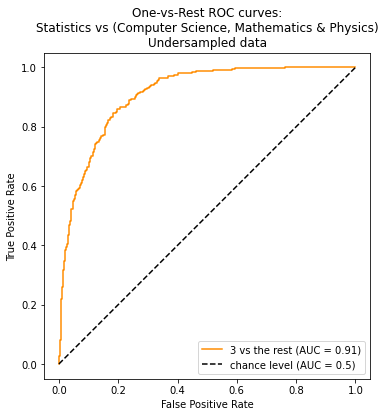

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    model.predict(X_test_tokenized_under)[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nStatistics vs (Computer Science, Mathematics & Physics)\nUndersampled data")
plt.legend()
plt.show()

45/45 [==============================] - 8s 167ms/step


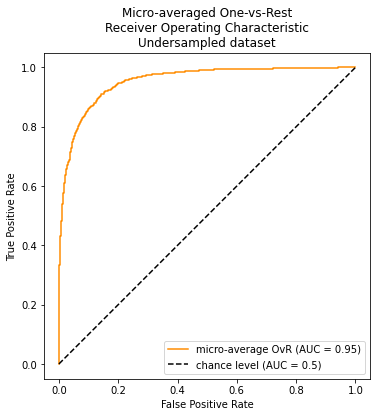

In [33]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    model.predict(X_test_tokenized_under).ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nUndersampled dataset")
plt.legend()
plt.show()